# CESM-LE comparison
 - reading in ensemble of data from CESM1_LENS, CESM2_LENS, and CESM2-CMIP5 a relatively large dataset 
 - calculations with 36 dask workers from casper tend to spill to disk
 - file IO from daniel kennedy, djk2120@ucar.edu
 - modified will wieder, wwieder@ucar.edu

In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import os
from scipy import stats
%matplotlib inline

In [2]:
## was working with 16.2
xr.__version__

'0.16.2'

In [3]:
## was working with 2020.12.0
dask.__version__

'2021.01.0'

### run this cell to check if you have LENS2 read access:

In [4]:
samplefile = ('/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1001.001/'+
              'lnd/proc/tseries/month_1/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.NBP.199001-199912.nc')
cmd = 'stat '+samplefile
if os.system(cmd)!=0:
    print('you may not have access')
else:
    print('looks good')

looks good


### Fetch cluster

In [5]:
#for use on Casper: ONLY RUN THIS CELL ONCE  
#   note you may need to change the project number
ncores = 36
nmem   = str(int(375*ncores/36))+'GB'
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=ncores,
                     processes=ncores, memory=nmem,
                     project='P93300641',
                     walltime='3:00:00')
cluster.scale(ncores)
client = Client(cluster)

In [9]:
# the extra workers can get stuck in the queue
#   stay here (rerunning cell) until you see that the workers>0
client

Client Scheduler: tcp://10.12.205.30:36941 Dashboard: http://10.12.205.30/proxy/8787/status,Cluster Workers: 36 Cores: 36 Memory: 375.12 GB


### Some helpful functions:
 - run all these before proceeding to the start here area:
 - you can certainly edit these, but shouldn't need to

In [10]:
def get_file(ee,model,field,yr):
    ''' Returns a given field from ensemble number ee for either CESM1 or CESM2'''
    if model == 'CESM1':
        topdir = ('/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'+
                  'lnd/proc/tseries/monthly/')
        matchme = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        lenskey = list(1+np.arange(35))+list(101+np.arange(7))
        nn      = lenskey[ee]
        ff = glob.glob(topdir+field+'/'+matchme+str(nn).zfill(3)+'*.nc')[0]

    if model == 'CESM2-CMIP5':
        topdir = '/glade/campaign/cesm/development/cross-wg/CESM2_CMIP5_forcings/' 
        mlist = sorted(glob.glob(topdir+'b.e21.BHIST.f09_g17.cesm2_cmip5_forcing*'))
        mm = mlist[ee]
        lnd    = '/lnd/proc/tseries/month_1/'
        ff     = glob.glob(mm+lnd+'*.h0.'+field+'*')[0]
        
    if model == 'CESM2':
        topdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
        mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17*'))
        mm = mlist[ee]
        lnd    = '/lnd/proc/tseries/month_1/'
        firstyear = 10*int(yr/10)
        yy    = '.'+str(firstyear)+'01-'+str(firstyear+9)+'12.'
        if yr>2009:
            yy = '.201001-201412.'
        ff     = glob.glob(mm+lnd+'*.h0.'+field+yy+'*')[0]
    return ff

In [11]:
topdir = '/glade/campaign/cesm/development/cross-wg/CESM2_CMIP5_forcings/' 
mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17*'))

topdir = '/glade/campaign/cesm/development/cross-wg/CESM2_CMIP5_forcings/' 
mlist = sorted(glob.glob(topdir+'b.e21.BHIST.f09_g17.cesm2_cmip5_forcing*'))
mm = mlist[1]
        
        #nn      = lenskey[ee]topdir = '/glade/campaign/cesm/development/cross-wg/CESM2_CMIP5_forcings/' 
#mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17*'))
print(mm)
    #mm = mlist[0]
#lnd    = '/lnd/proc/tseries/month_1/'
#ff     = glob.glob(mm+lnd+'*.h0.NBP*')[0]
#f

/glade/campaign/cesm/development/cross-wg/CESM2_CMIP5_forcings/b.e21.BHIST.f09_g17.cesm2_cmip5_forcing.002


In [12]:
def all_files(model,field,firstyear):
    ''' Returns all files for either CESM1 or CESM2, starting at firstyear'''
    if model == 'CESM1':
        nens = 7#42
        files = [get_file(ee,'CESM1',field,0) for ee in range(nens)]
    if model == 'CESM2-CMIP5':
        nens = 7
        files = [get_file(ee,'CESM2-CMIP5',field,0) for ee in range(nens)]
    if model =='CESM2':
        nens = 7#50
        yrs = [*np.arange(firstyear,2009,10),2010]
        files = [[get_file(ee,'CESM2',field,yr) for yr in yrs] 
                 for ee in range(nens)]
    return files

In [13]:
def get_monthly(model,fields,firstyear):
    first = True
    
    for field in fields:
        #find the appropriate files
        files = all_files(model,field,firstyear)
        
        #instantiation steps only required once
        if first:
            first = False
            # set up ensemble dimensions
            ensdim  = xr.DataArray(np.arange(len(files)), dims='ens', name='ens')
            ensdim.attrs['long_name']='ensemble number'
            concat_dim = {'CESM1':ensdim,'CESM2-CMIP5':ensdim,'CESM2':[ensdim,'time']}
            
            # instantiate ds
            if model=='CESM2':
                # LENS2 is split by decade, take only 1 copy of landfrac,area, etc.
                ds = xr.open_mfdataset(files[0],combine='by_coords',parallel=True)
                tmp = xr.open_dataset(files[0][0])
                for thisvar in tmp.data_vars:
                    if 'time' not in tmp[thisvar].coords:
                        ds[thisvar]=tmp[thisvar]
            else:
                ds = xr.open_dataset(files[0])

        tmp = xr.open_mfdataset(files,combine='nested',parallel=True,
                                concat_dim=concat_dim[model])
        ds[field] = tmp[field]

    ds['landarea'] = ds['area']*ds['landfrac']
    ds['landarea'].name = 'landarea'
    ds['landarea'].attrs['units'] = 'km2'
        
    nmonths = len(ds.time)
    yr0 = ds['time.year'][0].values
    ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')
    ix = ds['time.year']>=firstyear

    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        return ds.isel(time=ix)

In [14]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [15]:
# colorbrewer colormap, diverging, brown->green
ccc = np.zeros([11,3]);
ccc[0,:] = 84,48,5
ccc[1,:] = 140,81,10
ccc[2,:] = 191,129,45
ccc[3,:] = 223,194,125
ccc[4,:] = 246,232,195
ccc[5,:] = 245,245,245
ccc[6,:] = 199,234,229
ccc[7,:] = 128,205,193
ccc[8,:] = 53,151,143
ccc[9,:] = 1,102,94
ccc[10,:] = 0,60,48
ccc = matplotlib.colors.ListedColormap(ccc/256)

# Start editing here:
 - note: you don't have to %%time things
     - just wanted to give a sense of how long various steps take for me

### read in the data:
 - the less data you take, the faster this will run

In [16]:
%%time
#LENS1 starts in 1920, we'll do the same for LENS2

model = ['CESM1','CESM2-CMIP5','CESM2']
fields = ['NBP']  # always brackets, fields = ['GPP']
firstyear = 1850
dsCESM1 = get_monthly(model[0],fields,1920)
dsCMIP5 = get_monthly(model[1],fields,1850)
dsCESM2 = get_monthly(model[2],fields,1920)

CPU times: user 4.24 s, sys: 870 ms, total: 5.11 s
Wall time: 8.99 s


In [17]:
dsCMIP5

<xarray.Dataset>
Dimensions:       (ens: 7, hist_interval: 2, lat: 192, levdcmp: 25, levgrnd: 25, levlak: 10, lon: 288, time: 1140)
Coordinates:
  * levgrnd       (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levlak        (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp       (levdcmp) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * lon           (lon) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat           (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * time          (time) object 1920-01-01 00:00:00 ... 2014-12-01 00:00:00
  * ens           (ens) int64 0 1 2 3 4 5 6
Dimensions without coordinates: hist_interval
Data variables:
    area          (lat, lon) float32 ...
    landfrac      (lat, lon) float32 ...
    landmask      (lat, lon) float64 ...
    pftmask       (lat, lon) float64 ...
    nbedrock      (lat, lon) float64 ...
    ZSOI          (levgrnd, lat, lon) float32 ...
    DZSOI         (levgrnd, lat, lon) float32 ...
    WATSAT        (levgrnd, lat, lon) float32 ...
    SUCSAT        (levgrnd, lat, lon) float32 ...
    BSW           (levgrnd, lat, lon) float32 ...
    HKSAT         (levgrnd, lat, lon) float32 ...
    ZLAKE         (levlak, lat, lon) float32 ...
    DZLAKE        (levlak, lat, lon) float32 ...
    mcdate        (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    mcsec         (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    mdcur         (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    mscur         (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    nstep         (time) float64 dask.array<chunksize=(120,), meta=np.ndarray>
    time_bounds   (time, hist_interval) object dask.array<chunksize=(120, 2), meta=np.ndarray>
    date_written  (time) object dask.array<chunksize=(120,), meta=np.ndarray>
    time_written  (time) object dask.array<chunksize=(120,), meta=np.ndarray>
    NBP           (ens, time, lat, lon) float32 dask.array<chunksize=(1, 120, 192, 288), meta=np.ndarray>
    landarea      (lat, lon) float32 29.95 29.95 29.95 29.95 ... nan nan nan nan
Attributes:
    title:                                     CLM History file information
    comment:                                   NOTE: None of the variables ar...
    Conventions:                               CF-1.0
    history:                                   created on 02/05/20 23:20:51
    source:                                    Community Land Model CLM4.0
    hostname:                                  aleph
    username:                                  sunseon
    version:                                   cesm2.1.2-rc.03-18-g4ee0b23
    revision_id:                               $Id: histFileMod.F90 42903 201...
    case_title:                                UNSET
    case_id:                                   b.e21.BHISTcmip6.f09_g17.LE2-1...
    Surface_dataset:                           surfdata_0.9x1.25_hist_78pfts_...
    Initial_conditions_dataset:                arbitrary initialization
    PFT_physiological_constants_dataset:       clm5_params.c171117.nc
    ltype_vegetated_or_bare_soil:              1
    ltype_crop:                                2
    ltype_UNUSED:                              3
    ltype_landice_multiple_elevation_classes:  4
    ltype_deep_lake:                           5
    ltype_wetland:                             6
    ltype_urban_tbd:                           7
    ltype_urban_hd:                            8
    ltype_urban_md:                            9
    ctype_vegetated_or_bare_soil:              1
    ctype_crop:                                2
    ctype_crop_noncompete:                     2*100+m, m=cft_lb,cft_ub
    ctype_landice:                             3
    ctype_landice_multiple_elevation_classes:  4*100+m, m=1,glcnec
    ctype_deep_lake:                           5
    ctype_wetland:                             6
    ctype_urban_roof:      

## Plot cumulative NBP  
- each ensemble member, 1920-2005 or 2014

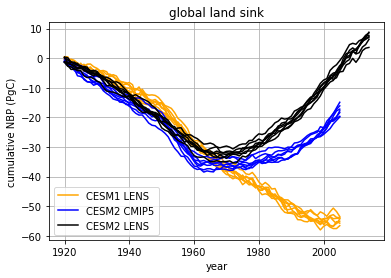

In [34]:
import matplotlib.lines as mlines
col = ['orange','blue','black']

for i in range(3):
    if i == 0: ds = dsCESM1
    if i == 1: ds = dsCMIP5
    if i == 2: ds = dsCESM2

    nyears  = len(np.unique(ds['time.year']))
    cf = 24*60*60           # used to convert /s to /d
    dpm = month_wts(nyears) # days per month
    nbp_ann = cf*(dpm*ds.NBP).groupby('time.year').sum(skipna=True) # gridded annual total nbp
    nbp_glob = (nbp_ann*ds['area']*ds['landfrac']).sum(dim=['lat','lon'],skipna=True) * 1e-9 #PgC
    if i == 1:
        nbp_glob = nbp_glob.isel(year=slice(70,None))

    cumsum = nbp_glob.cumsum(dim='year').values
    plt.plot(nbp_glob.year,cumsum,color=col[i])

plt.grid()
plt.ylabel('cumulative NBP (PgC)');
plt.xlabel('year')
plt.title('global land sink')
cesm1_line = mlines.Line2D([], [], color=col[0], label='CESM1 LENS')
cmip5_line = mlines.Line2D([], [], color=col[1], label='CESM2 CMIP5')
cesm2_line = mlines.Line2D([], [], color=col[2], label='CESM2 LENS')
plt.legend(handles=[cesm1_line,cmip5_line,cesm2_line]);